最適化されたパラメータ: [-10.           4.89329497  10.        ]
最小化された誤差: 0.40969716260173694


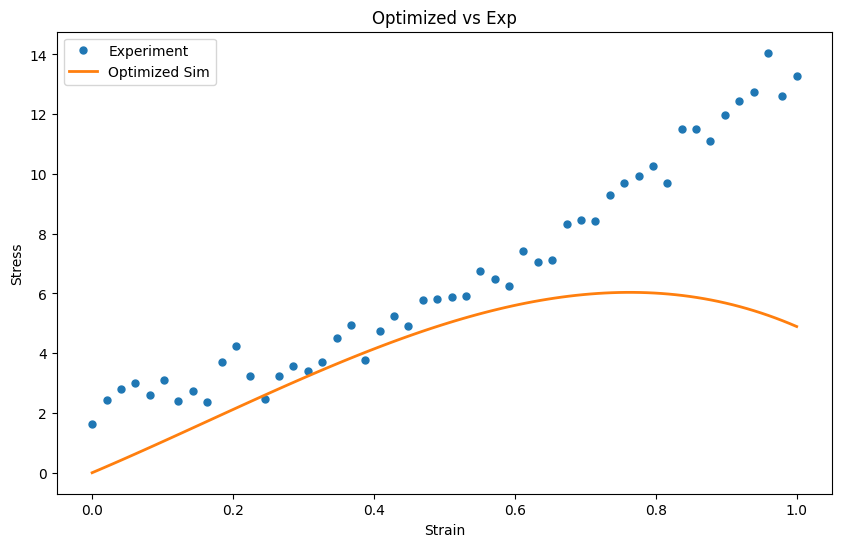

In [44]:
import numpy as np
import matplotlib.pyplot as plt
import json
from scipy.stats import gaussian_kde, entropy
from scipy.spatial import distance
from scipy.spatial.distance import jensenshannon
# 正解データの生成（実験データの模擬）
def generate_true_data(num_points=50):
    strain = np.linspace(0, 1, num_points)
    stress = 2 * strain**3 + 5 * strain**2 + 5 * strain + 2 + np.random.normal(0, 0.5, size=num_points)
    return strain, stress

# シミュレーション関数の定義
def simulation_function(params):
    a, b, c = params
    _sim_num_points = 100
    _strain = np.linspace(0, 1, _sim_num_points)
    _stress = a * _strain**3 + b * _strain**2 + c * _strain
    return np.array([_strain, _stress]).T

# 目的関数の定義（誤差を計算）
def objective_function(params, true_data):

    sim_data = simulation_function(params)
    metric = "JS_divergense"
    if metric == "euclide":
        # 正解データのポイントごとにSim結果とのユークリッド距離を計算
        euclidean_distances = distance.cdist(np.array(true_data), np.array(sim_data), 'euclidean')
        # ユークリッド距離の平均を計算
        mean_euclidean_distance = np.mean(np.diag(euclidean_distances))
        print(mean_euclidean_distance)
        return mean_euclidean_distance

    elif metric == "JS_divergense":
        kde1 = gaussian_kde(true_data.T)
        kde2 = gaussian_kde(sim_data.T)

        # グリッドの作成
        xgrid, ygrid = np.mgrid[-1:1.1:100j, -0.5:15.0:100j]
        positions = np.vstack([xgrid.ravel(), ygrid.ravel()])
        density1 = kde1(positions).reshape(xgrid.shape)
        density2 = kde2(positions).reshape(xgrid.shape)

        # Jensen-Shannon Divergenceの計算
        js_divergence = jensenshannon(density1.ravel(), density2.ravel()) ** 2
        return js_divergence

# 微分進化法の実装
def differential_evolution(func, bounds, true_data, args=(), max_iter=100, pop_size=15, mutation=0.8, recombination=0.7, tol=1e-6):
    dimensions = len(bounds)
    pop = np.random.rand(pop_size, dimensions)
    min_b, max_b = np.asarray(bounds).T
    diff = np.fabs(min_b - max_b)
    pop_denorm = min_b + pop * diff

    fitness = np.asarray([func(ind, true_data) for ind in pop_denorm])
    best_idx = np.argmin(fitness)
    best = pop_denorm[best_idx]

    # パラメータ履歴を記録
    history = []

    for i in range(max_iter):
        for j in range(pop_size):
            idxs = [idx for idx in range(pop_size) if idx != j]
            a, b, c = pop[np.random.choice(idxs, 3, replace=False)]
            mutant = np.clip(a + mutation * (b - c), 0, 1)
            cross_points = np.random.rand(dimensions) < recombination
            if not np.any(cross_points):
                cross_points[np.random.randint(0, dimensions)] = True
            trial = np.where(cross_points, mutant, pop[j])
            trial_denorm = min_b + trial * diff
            f = func(trial_denorm, true_data)

            if f < fitness[j]:
                fitness[j] = f
                pop[j] = trial
                if f < fitness[best_idx]:
                    best_idx = j
                    best = trial_denorm

            # パラメータを保存
            history.append({
                'iteration': i,
                'individual': j,
                'params': trial_denorm.tolist(),
                'error': f
            })

        if np.std(fitness) < tol:
            break

    return best, fitness[best_idx], history

# 正解データを生成
true_strain, true_stress = generate_true_data()

# 初期設計変数の範囲
bounds = [(-10, 10), (-10, 10), (-10, 10)]

# 最適化の実行
_true_data = np.array([true_strain, true_stress]).T
result, error, history = differential_evolution(objective_function, bounds, true_data=_true_data, args=(), max_iter=1000)

# 最適化結果の表示
print(f'最適化されたパラメータ: {result}')
print(f'最小化された誤差: {error}')

# JSONファイルにパラメータ履歴を保存
with open('optimization_history.json', 'w') as f:
    json.dump(history, f, indent=4)

# 最適化後のシミュレーションデータの生成
optimized_params = result
sim_optimized = simulation_function(optimized_params)

# プロット
plt.figure(figsize=(10, 6))
plt.plot(true_strain, true_stress, 'o', label='Experiment', markersize=5)
plt.plot(sim_optimized[:,0], sim_optimized[:,1], '-', label='Optimized Sim', linewidth=2)
plt.xlabel('Strain')
plt.ylabel('Stress')
plt.title('Optimized vs Exp')
plt.legend()
plt.show()


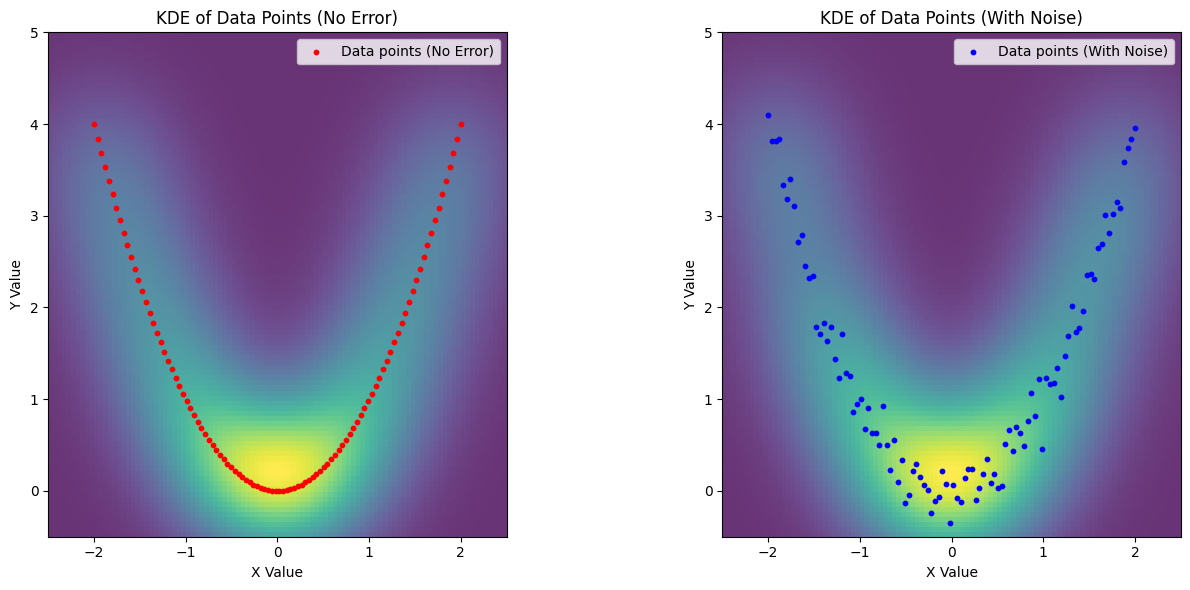

Wasserstein Distance (X): 0.0000
Wasserstein Distance (Y): 0.0550
Total Wasserstein Distance: 0.0550


In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde, wasserstein_distance

# 非線形関数の定義
def nonlinear_function(x):
    return x ** 2

# 点群の生成
np.random.seed(42)
x_values = np.linspace(-2, 2, 100)

# 点群1: 非線形関数に基づく（誤差なし）
y_values1 = nonlinear_function(x_values)

# 点群2: 非線形関数に基づく（正規分布に従う誤差を含む）
noise = np.random.normal(0, 0.2, size=x_values.shape)
y_values2 = nonlinear_function(x_values) + noise

# カーネル密度推定 (KDE) のためのデータの準備
data1 = np.vstack([x_values, y_values1])
data2 = np.vstack([x_values, y_values2])

# KDEを用いて密度推定
kde1 = gaussian_kde(data1)
kde2 = gaussian_kde(data2)

# グリッドの作成
xgrid, ygrid = np.mgrid[-2.5:2.5:100j, -0.5:5.0:100j]
positions = np.vstack([xgrid.ravel(), ygrid.ravel()])
density1 = kde1(positions).reshape(xgrid.shape)
density2 = kde2(positions).reshape(xgrid.shape)

# ウェッサースタイン距離の計算（1次元の場合）
w_distance_x = wasserstein_distance(x_values, x_values)
w_distance_y = wasserstein_distance(y_values1, y_values2)
w_distance_total = np.sqrt(w_distance_x**2 + w_distance_y**2)

# 結果の表示
plt.figure(figsize=(14, 6))

# 点群1の密度
plt.subplot(1, 2, 1)
plt.imshow(np.rot90(density1), extent=[-2.5, 2.5, -0.5, 5.0], cmap=plt.cm.viridis, alpha=0.8)
plt.scatter(x_values, y_values1, c='r', s=10, label='Data points (No Error)')
plt.title('KDE of Data Points (No Error)')
plt.xlabel('X Value')
plt.ylabel('Y Value')
plt.legend()

# 点群2の密度
plt.subplot(1, 2, 2)
plt.imshow(np.rot90(density2), extent=[-2.5, 2.5, -0.5, 5.0], cmap=plt.cm.viridis, alpha=0.8)
plt.scatter(x_values, y_values2, c='b', s=10, label='Data points (With Noise)')
plt.title('KDE of Data Points (With Noise)')
plt.xlabel('X Value')
plt.ylabel('Y Value')
plt.legend()

plt.tight_layout()
plt.show()

print(f'Wasserstein Distance (X): {w_distance_x:.4f}')
print(f'Wasserstein Distance (Y): {w_distance_y:.4f}')
print(f'Total Wasserstein Distance: {w_distance_total:.4f}')

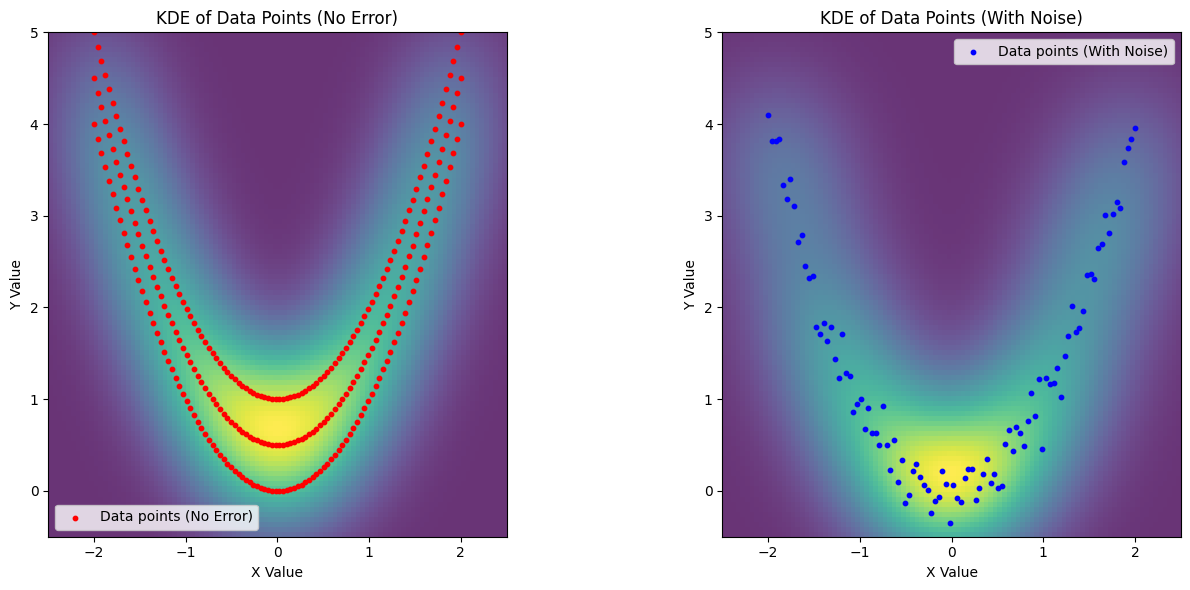

Jensen-Shannon Divergence: 0.0334


In [54]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde, entropy
from scipy.spatial.distance import jensenshannon

# 非線形関数の定義
def nonlinear_function(x):
    return x ** 2

# 点群の生成
np.random.seed(42)
x_values = np.linspace(-2, 2, 100)

# 点群1: 非線形関数に基づく（誤差なし）
y_values1 = nonlinear_function(x_values)

# 点群2: 非線形関数に基づく（正規分布に従う誤差を含む）
noise = np.random.normal(0, 0.2, size=x_values.shape)
y_values2 = nonlinear_function(x_values) + noise

# カーネル密度推定 (KDE) のためのデータの準備
data1 = np.vstack([x_values, y_values1])
data1_2 = np.vstack([x_values, y_values1 + 1])
data1_3 = np.vstack([x_values, y_values1 + 0.5])
data1 = np.hstack([data1, data1_2, data1_3])

data2 = np.vstack([x_values, y_values2])

# KDEを用いて密度推定
kde1 = gaussian_kde(data1)
kde2 = gaussian_kde(data2)

# グリッドの作成
xgrid, ygrid = np.mgrid[-2.5:2.5:100j, -0.5:5.0:100j]
positions = np.vstack([xgrid.ravel(), ygrid.ravel()])
density1 = kde1(positions).reshape(xgrid.shape)
density2 = kde2(positions).reshape(xgrid.shape)

# Jensen-Shannon Divergenceの計算
js_divergence = jensenshannon(density1.ravel(), density2.ravel()) ** 2

# 結果の表示
plt.figure(figsize=(14, 6))

# 点群1の密度
plt.subplot(1, 2, 1)
plt.imshow(np.rot90(density1), extent=[-2.5, 2.5, -0.5, 5.0], cmap=plt.cm.viridis, alpha=0.8)
plt.scatter(data1[0,:], data1[1::], c='r', s=10, label='Data points (No Error)')
plt.title('KDE of Data Points (No Error)')
plt.xlabel('X Value')
plt.ylabel('Y Value')
plt.legend()

# 点群2の密度
plt.subplot(1, 2, 2)
plt.imshow(np.rot90(density2), extent=[-2.5, 2.5, -0.5, 5.0], cmap=plt.cm.viridis, alpha=0.8)
plt.scatter(x_values, y_values2, c='b', s=10, label='Data points (With Noise)')
plt.title('KDE of Data Points (With Noise)')
plt.xlabel('X Value')
plt.ylabel('Y Value')
plt.legend()

plt.tight_layout()
plt.show()

# Jensen-Shannon Divergenceの結果の表示
print(f'Jensen-Shannon Divergence: {js_divergence:.4f}')


(3, 100)